In [1]:
#The directive "%" talks to Jupter Notebook directly
#matplotlib inline will embedd matplotlib graphs nicely within the code cells

%matplotlib inline

In [2]:
#import tool for accessing xml files:
import xml.etree.ElementTree as ET

import numpy as np
from numpy import asarray

#import Python Image Library (PIL)
from PIL import Image

#import matplotlib and patches to draw bounding boxes:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


#import keras
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image


#current path
import os
PATH = os.getcwd()
print(PATH)

/home/luc/Jupyter Notebooks/Object Localization/Dogs vs Cats


Using TensorFlow backend.


In [3]:
#define path of images to be trained
train_img_path = PATH + '/selected dataset/selected images/'

img_train = []

#lst = List of all images in train_img_path
lst = os.listdir(train_img_path)
#sort the lst alphabetically
lst.sort()

#length of the list
print(len(lst))


1985


In [4]:
#print first element of List lst
print(lst[0])

Abyssinian_1.jpg


In [5]:
#Set resized dimensions:
resized_width = 100
resized_height = 100


#For each image in lst, 
for sample in lst:
    #take the specific path to that image,
    img_path = train_img_path + sample
    #load that image,
    test_image = Image.open(img_path)
    #resize that image,
    test_image = test_image.resize((resized_width, resized_height), 3)
    #test_image = test_image.resize((resized_width, resized_height))
    #turn it into an array,
    data1 = asarray(test_image)
    #data1 = data1.reshape(resized_width, resized_height, 3)
    #expand that 3-dim array into 4-dim array.
    data = np.expand_dims(data1, axis=0)
    if img_path == train_img_path + lst[0]:
        #specify the first image/array to be the "total" img_array
        img_array = data
    else:
        #append all following arrays to the img_array
        #print(img_array.shape, data.shape, data1.shape, test_image.size)
        img_array = np.append(img_array, data, axis=0)
    
#for white-and-black pics (channels=1), we can normalize the data points:
#img_array = img_array / 255
#now we can limit the range of the values to be of type float32:
#img_array = img_array.astype('float32')

#check format: should be numpy.ndarray
print(type(img_array))
#check shape: should be (number of pics, width, height, colourdimension)
print(img_array.shape)


#If error occurs, that dimensions aren't correct (concatenate), there may be a black-and-white image in the set, 
#that cannot be transformed into (100,100,3). Solution: delete this image from the set

<class 'numpy.ndarray'>
(1985, 100, 100, 3)


In [6]:
#define path of labels
train_labels_path = PATH + '/selected dataset/selected xmls/'

#list all files in directory train_labels_path:
lst_label = os.listdir(train_labels_path)
#sort this list:
lst_label.sort()

#output this list:
#lst_label

In [7]:
print(type(lst_label))
print(lst_label[0])

<class 'list'>
Abyssinian_1.xml


In [8]:
label_array =[]
label_array_reg =[]

i=0

#For any xml-files in the lst_label list,
for sample_label in lst_label:
    #Count number of labels:
    i+=1
    #take its path,
    label_path = train_labels_path + sample_label
    #parse the xml file,
    xml = ET.parse(label_path)
    #get the root of the xml file.
    root_xml = xml.getroot()
    
    #Within the root, look for subbranch bndbox and iterate through its objects
    for bndbox in root_xml.iter('bndbox'):
    
        #fetch the coordinates:
        xmin = float(bndbox.find('xmin').text)
        ymin = float(bndbox.find('ymin').text)
        xmax = float(bndbox.find('xmax').text)
        ymax = float(bndbox.find('ymax').text)
        
    #Grab the original size of the image:    
    for orig_size in root_xml.iter('size'):
        
        width = float(orig_size.find('width').text)
        height = float(orig_size.find('height').text)
        
    #Within the root, look for the subbranch object and iterate through its objects    
    for animal_name in root_xml.iter('object'):
        
        #fetch the name of the animal
        animal = animal_name.find('name').text
        
        if animal == 'dog':
            animal = 1  
        else:
            animal = 0
    
    
    #Calculate the ratios needed to apply to the original-sized-image, in order to receive the resized-image
    #For x:
    x_ratio = resized_width/width
    #For y:
    y_ratio = resized_height/height
    
    
    
    #save the coordinates and the class label in a small label array; 
    #modify the coordinates with the corresponding ratios
    little_array2 = np.array([xmin*x_ratio, ymin*y_ratio, xmax*x_ratio, ymax*y_ratio])
    
    
    #save class labels in small label array
    little_array = np.array([animal])
    
    #If its the first xml label, 
    if label_path == train_labels_path + lst_label[0]:
        #then start off with the small array to be the "total" label array
        label_array = np.append(label_array, little_array)
    else:
        #otherwise, all other label arrays are appended to the "total" array
        label_array = np.append(label_array, little_array, axis=0)     
        
        
        #If its the first xml label, 
    if label_path == train_labels_path + lst_label[0]:
        #then start off with the small array to be the "total" label array
        label_array_reg = np.append(label_array_reg, little_array2)
    else:
        #otherwise, all other label arrays are appended to the "total" array
        label_array_reg = np.append(label_array_reg, little_array2, axis=0)   

        
        
#In the end, the number of labels is equivalent to the 4 parameter values times all the labels
#These values must be the same in order for the image and the label sets to match!
print(int(label_array_reg.shape[0]/4), i)

1985 1985


In [9]:
#Reshape to achieve format for bounding box values: (total number of labels, 4)    
label_array_reg = np.reshape(label_array_reg, (i,4))    

#Reshape to achieve format for class labels: (total number of labels, 1)    
label_array = np.reshape(label_array, (i,1))  

In [10]:
#check format: should be numpy.ndarray
print(type(label_array))
#check shape: should be (number of pics, number of labels)
#here: number of labels = 4 (xmin, ymin, xmax, ymax) + 1 (class name: 1 for dog, 0 for cat) = 5
print(label_array.shape)

print(type(label_array_reg))
print(label_array_reg.shape)
#print(label_array_reg)

<class 'numpy.ndarray'>
(1985, 1)
<class 'numpy.ndarray'>
(1985, 4)


In [11]:
#fixed:
num_classes = 2
num_regressions = 4
input_shape = (resized_width, resized_height, 3)

In [12]:
label_array = keras.utils.to_categorical(label_array, num_classes)

In [13]:
#may be adjusted:
batch_size = 8
epochs = 5

In [14]:
from keras.layers import Input, Dense
from keras.models import Model

In [15]:
print(type(img_array))
print(img_array.shape)

<class 'numpy.ndarray'>
(1985, 100, 100, 3)


In [16]:
inputs = tf.convert_to_tensor(img_array, dtype=tf.float32)
print(type(img_array))
print(img_array.shape)

<class 'numpy.ndarray'>
(1985, 100, 100, 3)


In [36]:
#Base model:

#This returns a tensor:
inputs = Input(shape=(resized_width, resized_height,3))
print(type(inputs), inputs.shape)

base = Conv2D(4, kernel_size=(3,3), activation='relu')(inputs)
base = MaxPooling2D(pool_size=(2,2))(base)

base = Conv2D(16, kernel_size=(3,3), activation='relu')(base)
base = MaxPooling2D(pool_size=(2,2))(base)

base = Conv2D(32, kernel_size=(3,3), activation='relu')(base)
#base = MaxPooling2D(pool_size=(2,2))(base)

<class 'tensorflow.python.framework.ops.Tensor'> (?, 100, 100, 3)


In [37]:
#Class head:

class_head = Flatten()(base)

class_head = Dense(64, activation='relu')(class_head)
#class_head = Dense(128, activation='relu')(class_head)
class_head = Dense(32, activation='relu')(class_head)


class_predictions = Dense(2, activation='sigmoid', name='class_output')(class_head)

print(class_predictions.shape)


(?, 2)


In [38]:
#Regression head:

regression_head = Flatten()(base)

regression_head = Dense(64, activation='relu')(regression_head)
#regression_head = Dense(128, activation='relu')(regression_head)
regression_head = Dense(32, activation='relu')(regression_head)

#Last layer should be regressionally trained, so have ReLU activation to preserve possibly high values
reg_predictions = Dense(num_regressions, activation='relu', name='reg_output')(regression_head)

In [39]:
#class Model: specify input layer and output layer

model = Model(inputs=inputs, outputs=[class_predictions, reg_predictions])

In [40]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 98, 98, 4)    112         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 49, 49, 4)    0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 47, 47, 16)   592         max_pooling2d_4[0][0]            
__________________________________________________________________________________________________
max_poolin

In [41]:
from keras.utils import plot_model

plot_model(model, to_file='class_prediction_head.png')

In [42]:
#losses = {'class_output': 'binary_crossentropy',
 #        'reg_output': 'mse'}

In [43]:
model.compile(optimizer='adam',
              loss={'class_output': 'binary_crossentropy',
         'reg_output': 'mse'},
              metrics=['accuracy'])

In [44]:
model.fit(img_array, {'class_output': label_array, 'reg_output': label_array_reg}, epochs=epochs, batch_size=batch_size)  # starts training

Epoch 1/5
1985/1985 [==============================] - 6s 3ms/step - loss: 1608.6421 - class_output_loss: 4.7187 - reg_output_loss: 1603.9235 - class_output_acc: 0.7043 - reg_output_acc: 0.2841
Epoch 2/5
1985/1985 [==============================] - 5s 2ms/step - loss: 1567.0850 - class_output_loss: 4.7243 - reg_output_loss: 1562.3607 - class_output_acc: 0.7053 - reg_output_acc: 0.2851
Epoch 3/5
1985/1985 [==============================] - 5s 2ms/step - loss: 1046.2809 - class_output_loss: 4.7243 - reg_output_loss: 1041.5566 - class_output_acc: 0.7053 - reg_output_acc: 0.4524
Epoch 4/5
1985/1985 [==============================] - 5s 2ms/step - loss: 258.5557 - class_output_loss: 4.7243 - reg_output_loss: 253.8314 - class_output_acc: 0.7053 - reg_output_acc: 0.7204
Epoch 5/5
1985/1985 [==============================] - 5s 2ms/step - loss: 204.0796 - class_output_loss: 4.7243 - reg_output_loss: 199.3553 - class_output_acc: 0.7053 - reg_output_acc: 0.7542


In [45]:
#Save models:

model.save("model.h5")
print("Saved Object Localization model to disk")

Saved Object Localization model to disk


In [46]:
from keras.models import load_model

model = load_model('model.h5')


In [47]:
from keras.preprocessing import image

#load image from 'test' folder to be predicted;
#transform them to the right size 100x100
#these images are totally new to the CNN
img = image.load_img(PATH + "/images/shiba_inu_51.jpg", target_size=(100, 100))
#make an array out of it
x = image.img_to_array(img)

# Add a forth dimension since Keras expects a list of images
x2 = np.expand_dims(x, axis=0)
# Make a prediction with the CNN
prediction = model.predict(x2)

#label was either [[1. 0.]] or [[0. 1.]]
#[[1. 0.]] means: cat
#[[0. 1.]] means: dog
print(prediction)

#Prediction output:
#prediction[0][0] will grab the first element of the array, prediction[0][1] the second
if prediction[0][0][0] > prediction[0][0][1]:
    print("It's a cat!")
else:
    print("It's a dog!")
    

[array([[9.29467e-33, 1.00000e+00]], dtype=float32), array([[36.09558 , 20.586826, 68.26302 , 51.594177]], dtype=float32)]
It's a dog!


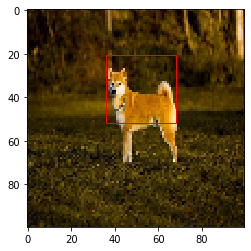

In [48]:
#prediction_reg = regression_head.predict(x2)
#print(prediction_reg)


xmin = prediction[1][0][0]
ymin = prediction[1][0][1]
xmax = prediction[1][0][2]
ymax = prediction[1][0][3]


# Create figure and axes
#Polar Subplot with
# x-Axis running from left to right
# y-Axis running from top to bottom
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(img)

#fig,ax = plt.subplots(1)

# Display the image
#ax.imshow(img)
rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=1,edgecolor='r', facecolor='none')

ax.add_patch(rect)